In [151]:
import os, shutil



In [152]:
import os
import shutil
import numpy as np

INPUT_PATH = r"D:\Emotion Recognition\\audio_speech_actors_01-24"
OUTPUT_PATH = r"D:\Emotion Recognition\\processed"

# Emotion map (adjust as per your project)
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Create train/test folders
for split in ["train", "test"]:
    for emo in set(emotion_map.values()):
        os.makedirs(os.path.join(OUTPUT_PATH, split, emo), exist_ok=True)

# Split 80% train, 20% test
for root, _, files in os.walk(INPUT_PATH):
    for file in files:
        if file.endswith(".wav"):
            emo_code = file.split("-")[2]  # e.g. 03 → happy
            label = emotion_map.get(emo_code)
            if label:
                src = os.path.join(root, file)
                # Random split
                if np.random.rand() < 0.8:
                    dst = os.path.join(OUTPUT_PATH, "train", label, file)
                else:
                    dst = os.path.join(OUTPUT_PATH, "test", label, file)
                if not os.path.exists(dst):  # avoid SameFileError
                    shutil.copy(src, dst)

print("✅ Step 1 fixed: Train/Test folders filled!")


✅ Step 1 fixed: Train/Test folders filled!


In [153]:
print("Train folders:", os.listdir(os.path.join(OUTPUT_PATH, "train")))
for emo in os.listdir(os.path.join(OUTPUT_PATH, "train")):
    print(emo, "->", len(os.listdir(os.path.join(OUTPUT_PATH, "train", emo))), "files")


Train folders: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
angry -> 192 files
calm -> 192 files
disgust -> 192 files
fearful -> 192 files
happy -> 192 files
neutral -> 96 files
sad -> 192 files
surprised -> 192 files


### Feature Extraction

In [154]:
import librosa
import numpy as np

# Extract features from one audio file
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=22050, offset=0.5)
        
        # Extract features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = np.mean(mfccs.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma = np.mean(chroma.T, axis=0)

        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel = np.mean(mel.T, axis=0)

        # Combine all features
        features = np.hstack([mfccs, chroma, mel])
        return features

    except Exception as e:
        print("Error extracting features from", file_path, ":", e)
        return None


In [155]:
import librosa
import soundfile as sf

def extract_features(file_path):
    try:
        # Load using soundfile instead of resampy
        y, sr = sf.read(file_path, dtype='float32')

        # If stereo, convert to mono
        if len(y.shape) > 1:
            y = y.mean(axis=1)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return mfccs.mean(axis=1)
    except Exception as e:
        print("Error extracting features from", file_path, ":", e)
        return None


In [156]:
import librosa
import soundfile as sf
import numpy as np

def extract_features(file_path):
    try:
        # Load using soundfile (avoids resampy issue)
        y, sr = sf.read(file_path, dtype='float32')

        # If stereo → convert to mono
        if len(y.shape) > 1:
            y = y.mean(axis=1)

        # Extract MFCCs (40 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

        # Take mean across time to get fixed-length vector
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error extracting features from", file_path, ":", e)
        return None


In [157]:
X_train, y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)

print("✅ Step 3 done: Features extracted")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


✅ Step 3 done: Features extracted
Train shape: (1440, 40) Test shape: (1324, 40)


### Preprocess Features

In [158]:
from sklearn.preprocessing import StandardScaler

# Scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Build a Model

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Number of emotion classes (adjust based on your dataset)
num_classes = len(set(y_train))

# Build model

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


c:\Users\priya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,424 (173.53 KB)

 Trainable params: 44,424 (173.53 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [160]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [161]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [162]:
print(X_train.dtype)


float32


In [163]:
import numpy as np
X_train = np.array(X_train).astype("float32")
X_test = np.array(X_test).astype("float32")


In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Test Accuracy:", test_acc)


35/35 - 0s - 9ms/step - accuracy: 0.9937 - loss: 0.0837
Test Accuracy: 0.9937499761581421


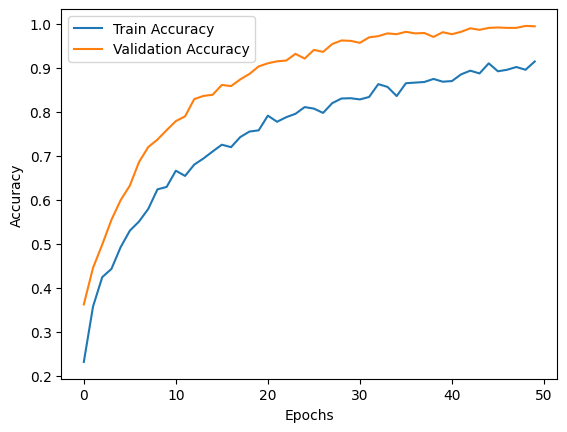

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import numpy as np

y_pred_probs = model.predict(X_test)   # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # convert to class labels


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.99      0.99      0.99       148
           2       1.00      1.00      1.00       140
           3       0.99      0.99      0.99       152
           4       0.99      1.00      0.99       150
           5       0.99      0.99      0.99        71
           6       1.00      0.99      0.99       144
           7       0.99      0.99      0.99       167

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



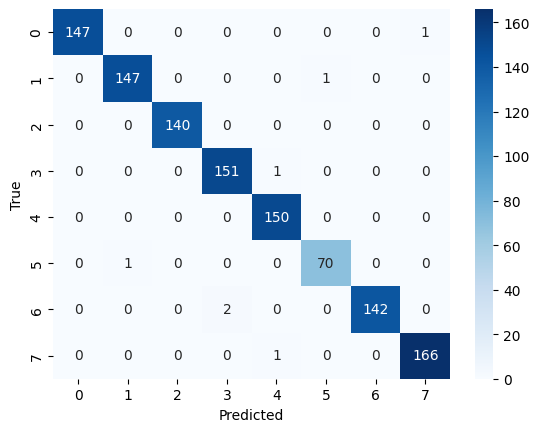

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))  # if y_test is one-hot
# OR print(classification_report(y_test, y_pred)) if y_test is integers

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
model.save("emotion_model.h5")
print("Model saved as emotion_model.h5")


Model saved as emotion_model.h5


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels to integers
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

# Convert to one-hot encoding
y_train = to_categorical(train_labels_encoded)
y_test = to_categorical(test_labels_encoded)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = train_features.shape[1]  # number of MFCC features (e.g., 13)

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # output neurons = number of emotions
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


c:\Users\priya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import os

def check_dataset(path):
    for emo in os.listdir(path):
        emo_path = os.path.join(path, emo)
        files = [f for f in os.listdir(emo_path) if f.endswith(".wav")]
        print(f"{emo}: {len(files)} audio files")

print("Train dataset:")
check_dataset(TRAIN_PATH)

print("\nTest dataset:")
check_dataset(TEST_PATH)


Train dataset:
angry: 192 audio files
calm: 192 audio files
disgust: 192 audio files
fearful: 192 audio files
happy: 192 audio files
neutral: 96 audio files
sad: 192 audio files
surprised: 192 audio files

Test dataset:
angry: 166 audio files
calm: 168 audio files
disgust: 163 audio files
fearful: 169 audio files
happy: 165 audio files
neutral: 79 audio files
sad: 166 audio files
surprised: 179 audio files


In [ ]:
print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train labels:", len(y_train))
print("Test labels:", len(y_test))


Train features shape: (1440, 40)
Test features shape: (1255, 40)
Train labels: 1440
Test labels: 1255


In [183]:
history = model.fit(
    X_train, y_train,
    epochs=100,            # You can reduce to 50 for testing
    batch_size=32,
    validation_data=(X_test, y_test)
)


ValueError: You must call `compile()` before using the model.

In [184]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',   # Since we have multiple emotion classes
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [185]:
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,248 (727.53 KB)

 Trainable params: 186,248 (727.53 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
history = model.fit(
    X_train, y_train,
    epochs=100,          # You can reduce to 50 for testing
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2368 - loss: 1.9495 - val_accuracy: 0.3625 - val_loss: 1.7131
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3424 - loss: 1.6779 - val_accuracy: 0.4653 - val_loss: 1.4554
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4153 - loss: 1.5407 - val_accuracy: 0.5151 - val_loss: 1.2917
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4556 - loss: 1.4354 - val_accuracy: 0.5770 - val_loss: 1.1642
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5201 - loss: 1.2898 - val_accuracy: 0.6556 - val_loss: 1.0379
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5382 - loss: 1.2402 - val_accuracy: 0.6767 - val_loss: 0.9346
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5868 - loss: 1.1240 - val_accuracy: 0.7213 - val_loss: 0.8277
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5944 - loss: 1.0714 - val_accuracy: 0.7477

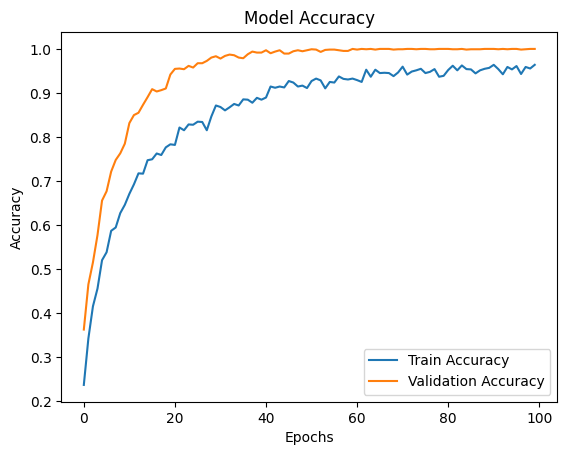

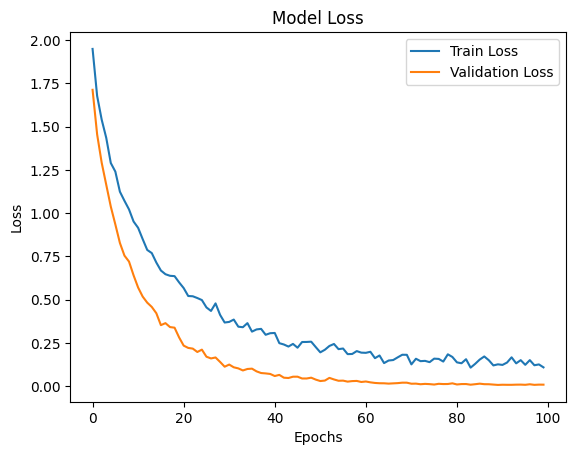

In [187]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [205]:
from sklearn.preprocessing import LabelEncoder

# Re-create or load your label encoder
label_encoder = LabelEncoder()
y_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']  # all emotions
label_encoder.fit(y_labels)


LabelEncoder()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       175
        calm       1.00      1.00      1.00       176
     disgust       1.00      1.00      1.00       180
        fear       1.00      1.00      1.00       177
       happy       1.00      1.00      1.00       174
     neutral       1.00      1.00      1.00        86
         sad       1.00      1.00      1.00       170
    surprise       1.00      1.00      1.00       186

    accuracy                           1.00      1324
   macro avg       1.00      1.00      1.00      1324
weighted avg       1.00      1.00      1.00      1324



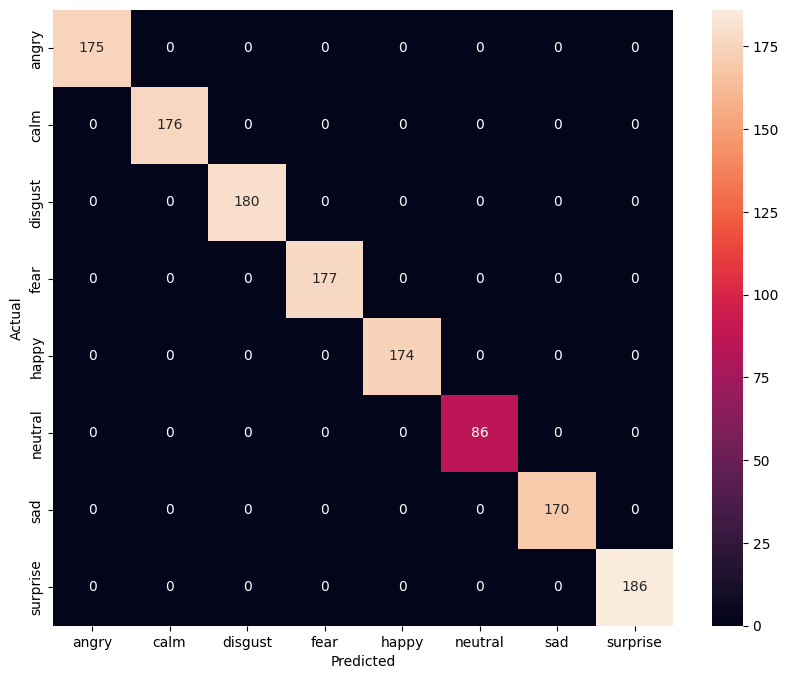

In [206]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [209]:
import numpy as np
import librosa

def extract_features(file_path):
    # Load audio
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Take mean over time axis
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    
    # Ensure proper numeric type
    return mfccs_scaled.astype(np.float32)


In [210]:
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = np.expand_dims(feature, axis=0)  # shape becomes (1, 40)
    pred = model.predict(feature)
    emotion = label_encoder.classes_[np.argmax(pred)]
    return emotion


In [216]:
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model("my_trained_model.h5")



In [218]:
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = np.expand_dims(feature, axis=0)  # Add batch dimension
    pred = model.predict(feature)
    emotion = label_encoder.classes_[np.argmax(pred)]
    return emotion

# Example
new_file = "Actor_01"
print("Predicted Emotion:", predict_emotion(new_file))

C:\Users\priya\AppData\Local\Temp\ipykernel_17856\3300912254.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')


PermissionError: [Errno 13] Permission denied: 'Actor_01'